# 📊 Analysis: Column Mapping Justification

This notebook explores the statistical and structural relationships between the columns to justify the inferred mapping.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load data and noise reduction
df = pd.read_csv("data.csv")
df.describe()

df_smoothed = df.copy()

columns_to_smooth = df.columns[:5]
span = min(1000, len(df) // 200) 

for column in columns_to_smooth:
    if df[column].dtype in ['int64', 'float64']:
        df_smoothed[column] = df[column].ewm(span=span, adjust=False).mean()
        print(f"Applied EWMA (span={span}) to column: {column}")

df_smoothed.to_csv('data_smoothed.csv', index=False)
print("Smoothed data saved to 'data_smoothed.csv'")

# comment the below line to remove noise reduction 
df = df_smoothed.copy() 


Applied EWMA (span=1000) to column: deltaX
Applied EWMA (span=1000) to column: gamma
Applied EWMA (span=1000) to column: omega
Applied EWMA (span=1000) to column: flux
Applied EWMA (span=1000) to column: pulse
Smoothed data saved to 'data_smoothed.csv'


### 🔍 Step 1: Identifying Volume

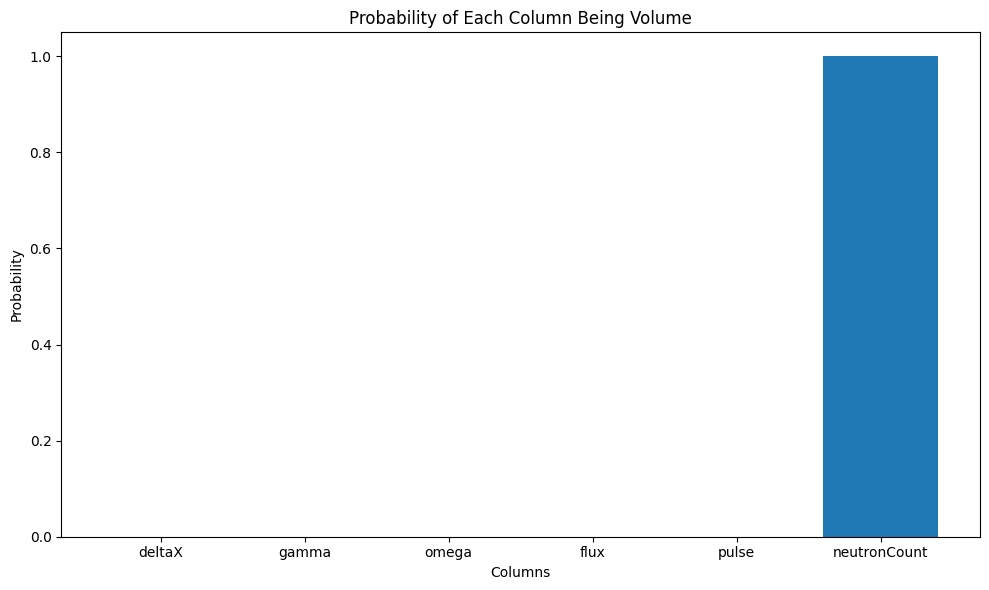

Thus, Column neutronCount is the most likely candidate for volume with confidence 1.0


In [2]:
volume_counts = {}
columns = df.columns
for col in columns:
    volume_counts[col]=0

for index,row in df.iterrows():
    candidates = []
    for col in columns:
        value = row[col]
        if value > 0 and value == int(value):
            candidates.append(col)
    if candidates:
        max_value = 0
        best_col = None
        for col in candidates:
            if row[col] > max_value:
                max_value = row[col]
                best_col = col
        volume_counts[best_col] += 1

for col,count in volume_counts.items():
    volume_counts[col] = count / len(df)
max_column_volume = max(volume_counts, key=volume_counts.get)
max_confidence = volume_counts[max_column_volume]

plt.figure(figsize=(10, 6))
plt.bar(volume_counts.keys(), volume_counts.values())
plt.title('Probability of Each Column Being Volume')
plt.xlabel('Columns')
plt.ylabel('Probability')
plt.tight_layout()
plt.show()

print(f"Thus, Column {max_column_volume} is the most likely candidate for volume with confidence {max_confidence}")

### 🔍 Step 2: Correlation Analysis


1. Pearson Correlation Matrix:
               deltaX    gamma    omega     flux    pulse  neutronCount
deltaX        1.00000  1.00000  1.00000  1.00000  1.00000      -0.00151
gamma         1.00000  1.00000  1.00000  1.00000  1.00000      -0.00151
omega         1.00000  1.00000  1.00000  1.00000  1.00000      -0.00151
flux          1.00000  1.00000  1.00000  1.00000  1.00000      -0.00151
pulse         1.00000  1.00000  1.00000  1.00000  1.00000      -0.00151
neutronCount -0.00151 -0.00151 -0.00151 -0.00151 -0.00151       1.00000

2. Spearman Correlation Matrix:
               deltaX    gamma    omega     flux    pulse  neutronCount
deltaX        1.00000  1.00000  1.00000  1.00000  1.00000      -0.00114
gamma         1.00000  1.00000  1.00000  1.00000  1.00000      -0.00114
omega         1.00000  1.00000  1.00000  1.00000  1.00000      -0.00114
flux          1.00000  1.00000  1.00000  1.00000  1.00000      -0.00114
pulse         1.00000  1.00000  1.00000  1.00000  1.00000      -0.00114

Text(0.5, 1.0, 'Spearman Correlation Matrix')

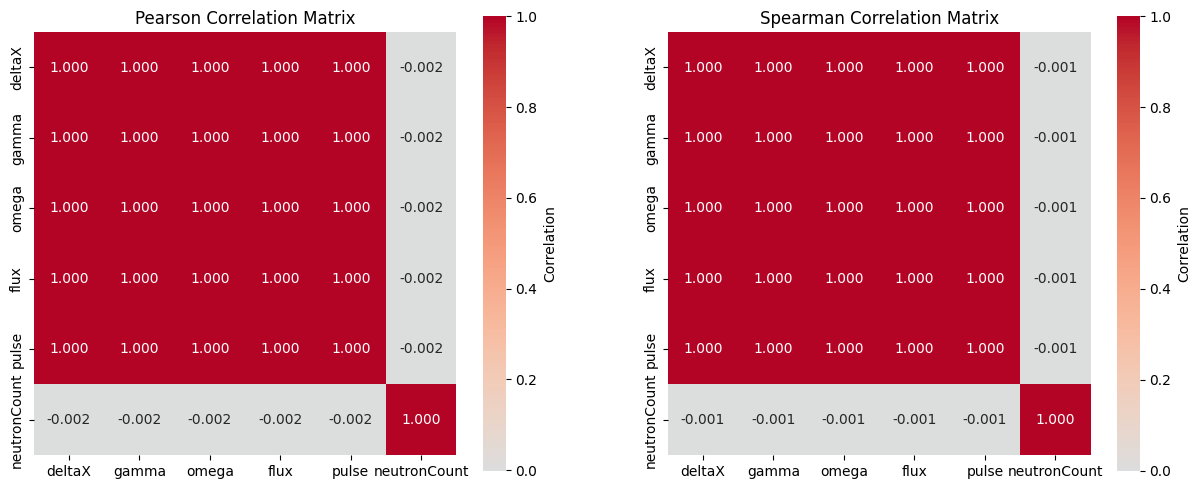

In [3]:
df.columns = df.columns.str.strip()

print("\n1. Pearson Correlation Matrix:")
pearson_corr = df.corr(method='pearson')
print(pearson_corr.round(5))

print("\n2. Spearman Correlation Matrix:")
spearman_corr = df.corr(method='spearman')
print(spearman_corr.round(5))

plt.figure(figsize=(15, 13))

plt.subplot(2, 2, 1)
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', center=0, square=True, fmt='.3f', cbar_kws={'label': 'Correlation'})
plt.title('Pearson Correlation Matrix')

plt.subplot(2, 2, 2)
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', center=0, square=True, fmt='.3f', cbar_kws={'label': 'Correlation'})
plt.title('Spearman Correlation Matrix')

### 🔍 Step 3: Row-wise Statistics inference (as applicable)

In [4]:
filtered_columns = [col for col in columns if col != max_column_volume]
incomings = {col : 0 for col in filtered_columns}
outgoings = {col : 0 for col in filtered_columns}

for high_col in filtered_columns:
    for low_col in filtered_columns:
        if high_col == low_col:
            continue
            
        if (df[high_col] >= df[low_col]).all():
            print(f"{high_col} >= {low_col} for all rows")
            incomings[low_col] += 1
            outgoings[high_col] += 1

filtered_low = [col for col, value in incomings.items() if value == max(incomings.values())]
filtered_high = [col for col, value in outgoings.items() if value == max(outgoings.values())]


print(f"\nMost incoming column: {filtered_low} with {max(incomings.values())} incoming connections")
print(f"Most outgoing column: {filtered_high} with {max(outgoings.values()) } outgoing connections")

deltaX >= omega for all rows
gamma >= deltaX for all rows
gamma >= omega for all rows
gamma >= flux for all rows
gamma >= pulse for all rows
flux >= omega for all rows

Most incoming column: ['omega'] with 3 incoming connections
Most outgoing column: ['gamma'] with 4 outgoing connections


Column deltaX is largest 0 times and smallest 0 times
Column gamma is largest 500000 times and smallest 0 times
Column omega is largest 0 times and smallest 499846 times
Column flux is largest 0 times and smallest 0 times
Column pulse is largest 0 times and smallest 154 times


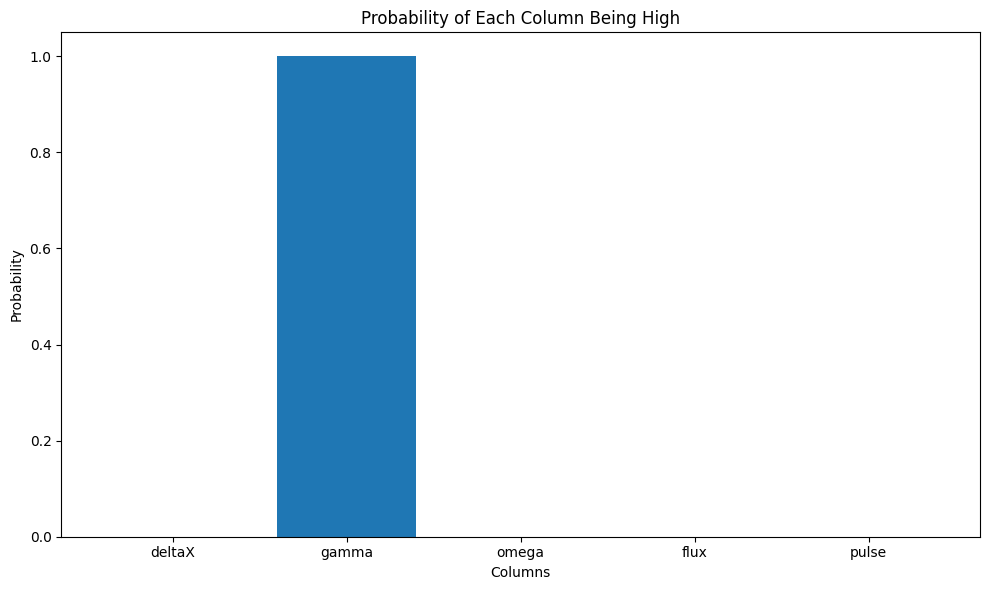

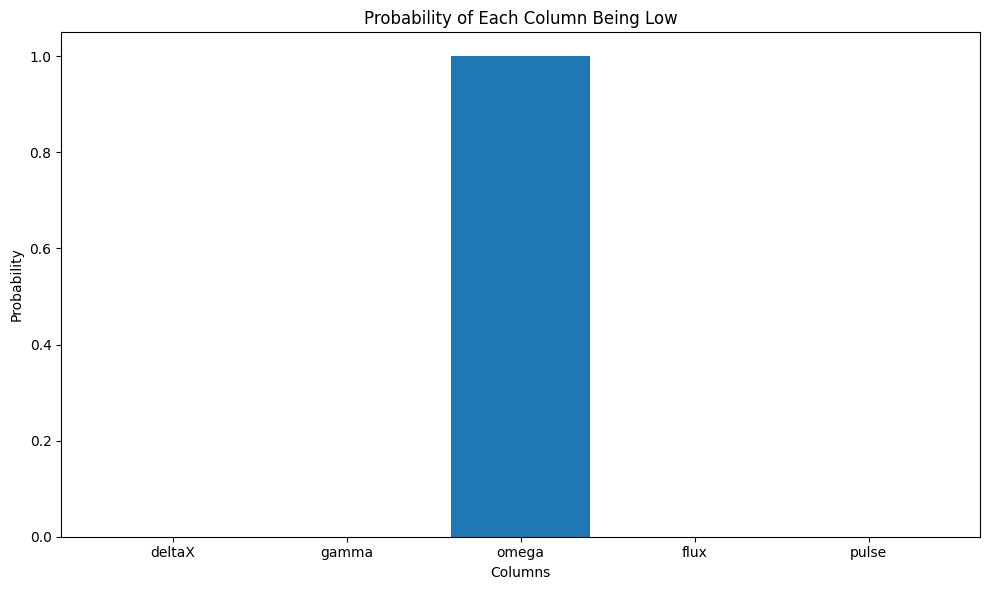

In [5]:
filtered_columns = [col for col in columns if col != max_column_volume]

df_subset = df[filtered_columns]

max_indices = df_subset.values.argmax(axis=1)
min_indices = df_subset.values.argmin(axis=1)

max_cols = df_subset.columns[max_indices]
min_cols = df_subset.columns[min_indices]

larger_counts = max_cols.value_counts()
smaller_counts = min_cols.value_counts()

larger = {col: larger_counts.get(col, 0) for col in filtered_columns}
smaller = {col: smaller_counts.get(col, 0) for col in filtered_columns}

if 'pulse' in filtered_columns:
    pulse_high_mask = max_cols == 'pulse'
    pulse_low_mask = min_cols == 'pulse'
    
    vol_pulse_large = df.loc[pulse_high_mask, max_column_volume].sum()
    vol_pulse_small = df.loc[pulse_low_mask, max_column_volume].sum()
else:
    vol_pulse_large = 0
    vol_pulse_small = 0

for col in filtered_columns:
    print(f"Column {col} is largest {larger[col]} times and smallest {smaller[col]} times")

total_rows = len(df)
larger_prob = {col: count / total_rows for col, count in larger.items()}
smaller_prob = {col: count / total_rows for col, count in smaller.items()}

# Find columns with highest probabilities
max_col_high = max(larger_prob, key=larger_prob.get)
max_col_low = max(smaller_prob, key=smaller_prob.get)

large_price = larger_prob[max_col_high]
small_price = smaller_prob[max_col_low]

# Find another column with non-zero probability
max_col_price = None
for col in filtered_columns:
    if ((larger_prob[col] > 0 or smaller_prob[col] > 0) and 
        col not in (max_col_high, max_col_low)):
        max_col_price = col
        break

# Create plots
plt.figure(figsize=(10, 6))
plt.bar(larger_prob.keys(), larger_prob.values())
plt.title('Probability of Each Column Being High')
plt.xlabel('Columns')
plt.ylabel('Probability')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(smaller_prob.keys(), smaller_prob.values())
plt.title('Probability of Each Column Being Low')
plt.xlabel('Columns')
plt.ylabel('Probability')
plt.tight_layout()
plt.show()

In [6]:
columns = df.columns.tolist()
print("Columns:", columns)

df_prev = df.shift(1)

results = []

for open_col in columns:
    for close_col in columns:
        if open_col == close_col or open_col == max_col_price or close_col == max_col_price:
            continue
        
        diff_sum = abs(df[open_col].iloc[1:] - df_prev[close_col].iloc[1:]).sum()
        
        results.append((open_col, close_col, diff_sum))
        print(f"{open_col}, {close_col}, {diff_sum}")

min_result = min(results, key=lambda x: x[2])
print(f"\nLowest difference: {min_result[0]} (open) vs {min_result[1]} (close) = {min_result[2]}")

Columns: ['deltaX', 'gamma', 'omega', 'flux', 'pulse', 'neutronCount']
deltaX, gamma, 96493.1077511037
deltaX, omega, 96022.66650225781
deltaX, flux, 7202.336869395582
deltaX, neutronCount, 25223079445.07115
gamma, deltaX, 95952.7921381999
gamma, omega, 192245.66865001508
gamma, flux, 95806.72744722958
gamma, neutronCount, 25222983222.069004
omega, deltaX, 96563.248948511
omega, gamma, 192786.1466900573
omega, flux, 96709.31363948129
omega, neutronCount, 25223175738.11009
flux, deltaX, 7200.824899200207
flux, gamma, 96347.12424350381
flux, omega, 96168.65000985768
flux, neutronCount, 25223079299.087646
neutronCount, deltaX, 25223052034.861145
neutronCount, gamma, 25222955811.9634
neutronCount, omega, 25223148327.737656
neutronCount, flux, 25223051888.79645

Lowest difference: flux (open) vs deltaX (close) = 7200.824899200207


In [7]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

feature_columns = columns

y = df[max_col_price].values
X_full = df.drop(columns=[max_col_price]).values

model.fit(X_full, y)

y_pred_full = model.predict(X_full)
exact_matches = (abs(y - y_pred_full) < 0.01).sum()

print("Analyzing how dropping each feature affects the model")

base_score = model.score(X_full, y)
base_matches = exact_matches

print(f"Baseline model R² score: {base_score:.6f}")
print(f"Baseline exact matches: {base_matches}/{len(y)}")

for col_to_drop in feature_columns:
    if col_to_drop == max_col_price:
        print(f"\nSkipping target variable: {max_col_price}")
        continue
        
    X_reduced = df.drop(columns=[max_col_price, col_to_drop]).values
    
    loo_model = LinearRegression().fit(X_reduced, y)
    score = loo_model.score(X_reduced, y)
    
    loo_y_pred = loo_model.predict(X_reduced)
    loo_exact_matches = (abs(y - loo_y_pred) < 0.01).sum()
    
    # Print results
    print(f"\nDropped feature: {col_to_drop}")
    print(f"R² score: {score:.6f} (change: {score - base_score:+.6f})")
    print(f"Exact matches: {loo_exact_matches}/{len(y)} (change: {loo_exact_matches - base_matches:+d})")

Analyzing how dropping each feature affects the model
Baseline model R² score: 1.000000
Baseline exact matches: 479788/500000

Dropped feature: deltaX
R² score: 1.000000 (change: -0.000000)
Exact matches: 477377/500000 (change: -2411)

Dropped feature: gamma
R² score: 1.000000 (change: -0.000000)
Exact matches: 479635/500000 (change: -153)

Dropped feature: omega
R² score: 1.000000 (change: -0.000000)
Exact matches: 479897/500000 (change: +109)

Dropped feature: flux
R² score: 1.000000 (change: -0.000000)
Exact matches: 478125/500000 (change: -1663)

Skipping target variable: pulse

Dropped feature: neutronCount
R² score: 1.000000 (change: -0.000000)
Exact matches: 479793/500000 (change: +5)


In [8]:
candidate_open_close = [col for col in filtered_columns if col not in {max_col_high, max_col_low, max_col_price}]
print(f"Candidate columns: {candidate_open_close}")

candidate_data = df[candidate_open_close].values
n_rows = len(df) - 1

results = []

for i, candidate_open in enumerate(candidate_open_close):
    for j, candidate_close in enumerate(candidate_open_close):
        if i == j:
            continue

        open_col = candidate_data[:, i]
        close_col = candidate_data[:, j]

        o1, o2 = open_col[:-1], open_col[1:]
        c1, c2 = close_col[:-1], close_col[1:]

        condition1 = (o1 > c1) & (o2 > c2) & (o1 > c2)
        condition2 = (o1 < c1) & (o2 < c2) & (o1 < c2)

        same = np.sum(condition1 | condition2)
        same_ratio = same / n_rows

        results.append({
            'open_col': candidate_open,
            'close_col': candidate_close,
            'same_absolute': same,
            'same_ratio': same_ratio
        })
        
        print(f"Analyzing open: {candidate_open} and close: {candidate_close}")
        print(f"Same absolute: {same}")
        print(f"Same ratio: {same_ratio:.4f}")
        print()



Candidate columns: ['deltaX', 'flux']
Analyzing open: deltaX and close: flux
Same absolute: 329448
Same ratio: 0.6589

Analyzing open: flux and close: deltaX
Same absolute: 321457
Same ratio: 0.6429



In [9]:
size = len(df)

for i, candidate_open in enumerate(candidate_open_close):
    for j, candidate_close in enumerate(candidate_open_close):
        if i == j:
            continue
        
        works = 0
        
        open_data = df[candidate_open].values
        close_data = df[candidate_close].values
        
        for k in range(0, size, 1000):
            end_idx = min(k + 1000, size)
            chunk_end = min(k + 999, size - 1)
            
            total_diff = close_data[chunk_end] - open_data[k]
            
            chunk_open = open_data[k:end_idx]
            chunk_close = close_data[k:end_idx]
            candidate_sum = np.sum(chunk_close - chunk_open)
            
            if (candidate_sum > 0 and total_diff > 0) or (candidate_sum < 0 and total_diff < 0):
                works += 1
        
        print(f"Analyzing {candidate_open} -> {candidate_close}: {works}")


Analyzing deltaX -> flux: 258
Analyzing flux -> deltaX: 242


In [10]:
print(candidate_open_close)

df.columns = df.columns.str.strip()
columns = df.columns.tolist()

print("Columns:", columns)

df_prev = df.shift(1)

results = []
best_open_percentage = float('inf')
max_open_col = None
max_close_col = None

for i, candidate_open in enumerate(candidate_open_close):
  for j, candidate_close in enumerate(candidate_open_close):
      if i == j:
          continue

      price_col = max_col_price

      closecount = 0
      opencount = 0
      
      open_distance = abs(df[price_col] - df_prev[candidate_open])
      close_distance = abs(df[price_col] - df_prev[candidate_close])
          
      closer_to_open = (open_distance < close_distance).sum()
      closer_to_close = (close_distance < open_distance).sum()
          
      opencount += closer_to_open
      closecount += closer_to_close
      
      open_percentage = 100 * opencount / (opencount + closecount)
      
      print(f"Open: {candidate_open}, Close: {candidate_close}, Price: {price_col}")
      print(f"Closer to Open: {opencount}")
      print(f"Closer to Close: {closecount}")
      print(f"Open % (lower the better): {open_percentage:.2f}")
      
      results.append({
          'open_col': candidate_open,
          'close_col': candidate_close,
          'open_percentage': open_percentage,
          'opencount': opencount,
          'closecount': closecount
    })
      
      if open_percentage < best_open_percentage:
          best_open_percentage = open_percentage
          max_open_col = candidate_open
          max_close_col = candidate_close

print(f"\nOptimal combination:")
print(f"max_open_col: {max_open_col}")
print(f"max_close_col: {max_close_col}")
print(f"Best open percentage: {best_open_percentage:.2f}%")

['deltaX', 'flux']
Columns: ['deltaX', 'gamma', 'omega', 'flux', 'pulse', 'neutronCount']
Open: deltaX, Close: flux, Price: pulse
Closer to Open: 250878
Closer to Close: 249121
Open % (lower the better): 50.18
Open: flux, Close: deltaX, Price: pulse
Closer to Open: 249121
Closer to Close: 250878
Open % (lower the better): 49.82

Optimal combination:
max_open_col: flux
max_close_col: deltaX
Best open percentage: 49.82%


### 📈 Step 4: Candlestick Visual from Mapped Fields

In [ ]:
# If you already have df loaded and mapped, skip to the renaming step.
import mplfinance as mpf
df = pd.read_csv("data.csv")

ohlc = df.rename(columns={
    'deltaX': 'open',
    'gamma': 'high',
    'omega': 'low',
    'flux': 'close'
})

if 'timestamp' not in ohlc.columns:
    ohlc['timestamp'] = pd.date_range('2024-01-01', periods=len(ohlc), freq='T')

ohlc = ohlc[['timestamp', 'open', 'high', 'low', 'close']]

ohlc.to_csv('grafana_ohlc.csv', index=False)


ohlc = pd.read_csv('grafana_ohlc.csv', parse_dates=['timestamp'])

ohlc.set_index('timestamp', inplace=True)

mpf.plot(
    ohlc,
    type='candle',
    style='charles',
    title='OHLC Candlestick Preview',
    ylabel='Price',
    figsize=(12, 6)
)

/tmp/ipykernel_105367/1481315730.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ohlc['timestamp'] = pd.date_range('2024-01-01', periods=len(ohlc), freq='T')
/home/mostlyk/.local/lib/python3.13/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


This confirms the structural pattern of price movement and supports the inferred mapping.